# Statistics of fuji + guadalupe and targets with multiple spectra

April 2022

Angela Berti, Ragadeepika Pucha, Stephanie Juneau, Anthony Kremin<br>
This notebook has been tested with the DESI master kernel.

### Table of Contents
* [Overview](#overview)
* [Imports](#imports)
* [Accessing the data at NERSC](#data)
* [Catalog statistics by survey](#stats_survey)
  * [Unique targets in each survey](#counts_survey_total)
  * [Survey Validation (SV) versus Main Survey targets](#counts_sv_main_unique)
* [Primary spectra](#primary)
* [Catalog statistics by target type](#stats_target)
  * [DESI target masks](#masks_desi)
  * [Spectra by target type](#counts_target)
* [Redshift distributions by target type and survey](#redshift_dist)
* [Target counts by target type and survey](#counts_target_survey)
* [Targets with multiple spectra](#multispec)
  * [Multiple SPECTYPE classifications](#spectype_diff)
  * [Bright versus dark time spectra of the same target](#bright_dark)

<a class="anchor" id="overview"></a>
## Overview
This notebook is a companion to `Fujilupe_CombineZcat.ipynb`, which demonstrates how combine the [fuji](https://desi.lbl.gov/trac/wiki/Pipeline/Releases/Fuji) and [guadalupe](https://desi.lbl.gov/trac/wiki/Pipeline/Releases/Guadalupe) data releases into a single catalog, flag a unique set of the primary (i.e., best) spectrum for each object in the catalog, and apply some basic quality cuts. This notebook provides examples of how break down the data in the combined catalog by target type (BGS, LRG, etc.), survey (SV, main, etc.), and the number of spectra per target. It also covers how to extract and plot different spectra of the same target.

<a class="anchor" id="imports"></a>
## Imports

In [1]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

#-- input/output functions related to DESI spectra
import desispec.io


In [2]:
#-- specify format of plots

settings = {
    "font.size": 22,
    "axes.linewidth": 2.0,
    "xtick.major.size": 6.0,
    "xtick.minor.size": 4.0,
    "xtick.major.width": 2.0,
    "xtick.minor.width": 1.5,
    "xtick.direction": "in", 
    "xtick.minor.visible": True,
    "xtick.top": True,
    "ytick.major.size": 6.0,
    "ytick.minor.size": 4.0,
    "ytick.major.width": 2.0,
    "ytick.minor.width": 1.5,
    "ytick.direction": "in", 
    "ytick.minor.visible": False,
    "ytick.right": True,
}

plt.rcParams.update(**settings)


<a class="anchor" id="data"></a>
## Accessing the data

The notebook `Fujilupe_CombineZcat.ipynb` shows how this catalog is constructed, and can also be used as a guide to create your own version with just the columns needed for your science case. To load the combined fuji + guadalupe (fujilupe) catalog with *all* available columns:


In [3]:
%%time

fujilupe = Table( fitsio.read("/global/cfs/cdirs/desi/science/gqp/zcatalog_summary/zall-pix-fujilupe.fits") )


CPU times: user 14.1 s, sys: 4.11 s, total: 18.2 s
Wall time: 18.6 s


<a class="anchor" id="stats_survey"></a>

## Statistics of the combined catalog by survey

<a class="anchor" id="masks_survey"></a>

### Create masks to select each survey

In [4]:
#-- main survey
is_main = (fujilupe["SURVEY"].astype(str).data == "main")

#-- SV1/2/3
is_sv1 = (fujilupe["SURVEY"].astype(str).data == "sv1")
is_sv2 = (fujilupe["SURVEY"].astype(str).data == "sv2")
is_sv3 = (fujilupe["SURVEY"].astype(str).data == "sv3")

#-- all SV data
is_sv = (is_sv1 | is_sv2 | is_sv3)

#-- commissioning data
is_cmx = (fujilupe["SURVEY"].astype(str).data == "cmx")

#-- special tiles
is_special = (fujilupe["SURVEY"].astype(str).data == "special")


<a class="anchor" id="counts_survey_total"></a>

### Identify the total number of unique targets observed in each survey, as well as in the combined catalog

Uncomment specific lines to print numbers for additional surveys.

In [5]:
#-- all unique targets in the main survey
targids_main = np.unique(fujilupe["TARGETID"][is_main])

#-- all unique targets in SV
targids_sv = np.unique(fujilupe["TARGETID"][is_sv])

print("Unique targets in main survey:{0:8}".format( len(targids_main) ))
print("Unique targets in SV:         {0:8}".format( len(targids_sv) ))

print("\nTotal unique targets in combined catalog: {}\n".format( len(np.unique(fujilupe["TARGETID"])) ))

# print("Unique targets in SV1:    {0:8}".format( len(np.unique(fujilupe["TARGETID"][is_sv1])) ))
# print("Unique targets in SV2:    {0:8}".format( len(np.unique(fujilupe["TARGETID"][is_sv2])) ))
# print("Unique targets in SV3:    {0:8}".format( len(np.unique(fujilupe["TARGETID"][is_sv3])) ))

# print("\nUnique targets in CMX:    {0:8}".format( len(np.unique(fujilupe["TARGETID"][is_cmx])) ))

# print("\nUnique targets in Special:{0:8}".format( len(np.unique(fujilupe["TARGETID"][is_special])) ))


Unique targets in main survey: 3167209
Unique targets in SV:          2704365

Total unique targets in combined catalog: 5859563



Note that the total number of unique targets in the combined catalog is close to, but not exactly, the total of unique targets in the main survey and in SV. This is because some targets are observed in both surveys, and because a (relatively small) number of targets are from commissioning and special tiles.

<a class="anchor" id="counts_sv_main_unique"></a>

### How many unique targets are in only the main survey, only SV, or both?

In [6]:
print("Unique targets in...\n")
print("  main survey and not SV: {0:8}".format(len(list(set(targids_main).difference(targids_sv))) ))
print("  SV and not main survey: {0:8}".format(len(list(set(targids_sv).difference(targids_main))) ))
print("  both main survey and SV:{0:8}".format(len(list(set(targids_main).intersection(targids_sv))) ))


Unique targets in...

  main survey and not SV:  3089804
  SV and not main survey:  2626960
  both main survey and SV:   77405


<a class="anchor" id="primary"></a>

## Primary spectra

The combined catalog contains columns that flag the set of primary spectra within just the main survey (`MAIN_PRIMARY`), just SV data (`SV_PRIMARY`), and the across entire catalog (`ZCAT_PRIMARY`). Note that the set of primary spectra identified within just main survey data or just SV data (`SV_PRIMARY` flag) is *not* the same as identifying primary spectra across the entire combined catalog and *then* selecting by survey, i.e.,

$$
\begin{align}
\texttt{fujilupe}["\!\texttt{ZCAT}\_\texttt{PRIMARY}\!"][\ \texttt{is}\_\texttt{main}\ ] &\neq \texttt{fujilupe}["\!\texttt{MAIN}\_\texttt{PRIMARY}\!"] \\
\texttt{fujilupe}["\!\texttt{ZCAT}\_\texttt{PRIMARY}\!"][\ \texttt{is}\_\texttt{sv}\ ] &\neq \texttt{fujilupe}["\!\texttt{SV}\_\texttt{PRIMARY}\!"] 
\end{align}
$$

<a class="anchor" id="counts_survey_unique"></a>
### How many primary spectra are in the main survey, SV, the combined catalog, and other surveys?
Uncomment specific lines to print numbers for other surveys.

In [7]:
print("Primary spectra in...\n")
print("  main survey:     {0:8}".format( len(fujilupe[is_main & fujilupe["MAIN_PRIMARY"]]) ))
print("  SV:              {0:8}".format( len(fujilupe[is_sv & fujilupe["SV_PRIMARY"]]) ))
print("  combined catalog:{0:8}\n".format( len(fujilupe[fujilupe["ZCAT_PRIMARY"]]) ))

# print("  SV1:    {0:8}".format( len(fujilupe[is_sv1 & fujilupe["SV_PRIMARY"]]) ))
# print("  SV2:    {0:8}".format( len(fujilupe[is_sv2 & fujilupe["SV_PRIMARY"]]) ))
# print("  SV3:    {0:8}\n".format( len(fujilupe[is_sv3 & fujilupe["SV_PRIMARY"]]) ))

# print("  CMX:    {0:8}\n".format( len(fujilupe[is_cmx & fujilupe["ZCAT_PRIMARY"]]) ))

# print("  Special:{0:8}".format( len(fujilupe[is_special & fujilupe["ZCAT_PRIMARY"]]) ))


Primary spectra in...

  main survey:      3167209
  SV:               2704365
  combined catalog: 5859563



As expected, the total number of primary spectra in the combined catalog is exactly the number of unique targets in this catalog (see above).

<a class="anchor" id="stats_target"></a>
## Statistics of the combined catalog by target type

<a class="anchor" id="masks_desi"></a>
### DESI target masks

Targeting bits are encoded in `desi_mask`, which can be imported from `desitarget.targetmask` or from any of the SV libraries (e.g., from `desitarget.sv1.sv1_targetmask`, etc.). While not universally true, for the purposes of this notebook it doesn"t matter which `desi_mask` is used; any of the four import options below will give the same results.


In [8]:
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask          # main survey
# from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask  # SV1
# from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask  # SV2
# from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask  # SV3


In [9]:
#-- select the target mask for each type of target (BGS, LRG, ELG, QSO, etc.)

bgs_tgtmask  = desi_mask["BGS_ANY"]
lrg_tgtmask  = desi_mask["LRG"]
elg_tgtmask  = desi_mask["ELG"]
qso_tgtmask  = desi_mask["QSO"]
mws_tgtmask  = desi_mask["MWS_ANY"]
scnd_tgtmask = desi_mask["SCND_ANY"]


<a class="anchor" id="masks_target"></a>

### Define masks to select all targets of each type from the combined catalog

Information about DESI target selection is stored in the `DESI_TARGET` column. Similarly, the `SV1_DESI_TARGET`, `SV2_DESI_TARGET`, and `SV3_DESI_TARGET` columns indicate which objects were targeted specifically during SV. The masks below select *all* targets of a given type.


In [10]:
desi_target = fujilupe["DESI_TARGET"]

#-- all BGS targets
is_bgs = (desi_target & bgs_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & bgs_tgtmask != 0) | \
         (fujilupe["SV2_DESI_TARGET"] & bgs_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & bgs_tgtmask != 0)

#-- all LRG targets
is_lrg = (desi_target & lrg_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & lrg_tgtmask != 0) | \
         (fujilupe["SV2_DESI_TARGET"] & lrg_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & lrg_tgtmask != 0)

#-- all ELG targets
is_elg = (desi_target & elg_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & elg_tgtmask != 0) | \
         (fujilupe["SV2_DESI_TARGET"] & elg_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & elg_tgtmask != 0)

#-- all QSO targets
is_qso = (desi_target & qso_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & qso_tgtmask != 0) | \
         (fujilupe["SV2_DESI_TARGET"] & qso_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & qso_tgtmask != 0)

#-- all Milky Way targets
is_mws = (desi_target & mws_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & mws_tgtmask != 0) | \
         (fujilupe["SV2_DESI_TARGET"] & mws_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & mws_tgtmask != 0)

#-- all secondary targets
is_scnd = (desi_target & scnd_tgtmask != 0) | (fujilupe["SV1_DESI_TARGET"] & scnd_tgtmask != 0) | \
          (fujilupe["SV2_DESI_TARGET"] & scnd_tgtmask != 0) | (fujilupe["SV3_DESI_TARGET"] & scnd_tgtmask != 0)


<a class="anchor" id="counts_target"></a>
### Plot the total number of spectra of each target type


In [11]:
#-- total number of spectra by target type
n_bgs  = len(fujilupe[is_bgs])
n_lrg  = len(fujilupe[is_lrg])
n_elg  = len(fujilupe[is_elg])
n_qso  = len(fujilupe[is_qso])
n_mws  = len(fujilupe[is_mws])
n_scnd = len(fujilupe[is_scnd])

counts = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

#-- number of primary spectra by target type
is_primary = fujilupe["ZCAT_PRIMARY"]

n_bgs_prim  = len(fujilupe[is_bgs & is_primary])
n_lrg_prim  = len(fujilupe[is_lrg & is_primary])
n_elg_prim  = len(fujilupe[is_elg & is_primary])
n_qso_prim  = len(fujilupe[is_qso & is_primary])
n_mws_prim  = len(fujilupe[is_mws & is_primary])
n_scnd_prim = len(fujilupe[is_scnd & is_primary])

counts_prim = [n_bgs_prim, n_lrg_prim, n_elg_prim, n_qso_prim, n_mws_prim, n_scnd_prim]


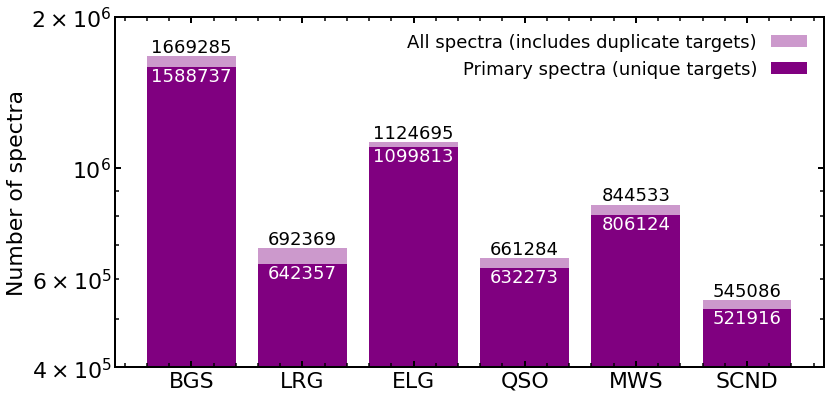

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

targets = ["BGS", "LRG", "ELG", "QSO", "MWS", "SCND"]

ax.bar(targets, counts, color="purple", alpha=0.4, label="All spectra (includes duplicate targets)")
ax.bar(targets, counts_prim, color="purple", alpha=1, label="Primary spectra (unique targets)")
ax.set_ylabel("Number of spectra")
ax.semilogy()
ax.set_ylim(4e5, 2e6)

for i in range(len(targets)):
    ax.text(targets[i], counts[i], counts[i], ha="center", va="bottom", fontsize=18)
    ax.text(targets[i], counts_prim[i], counts_prim[i], ha="center", va="top", fontsize=18, color="white")

plt.legend(fontsize=18, frameon=False, markerfirst=False)
plt.tight_layout()
plt.show()


<a class="anchor" id="redshift_dist"></a>

## Redshift distributions by target type and survey

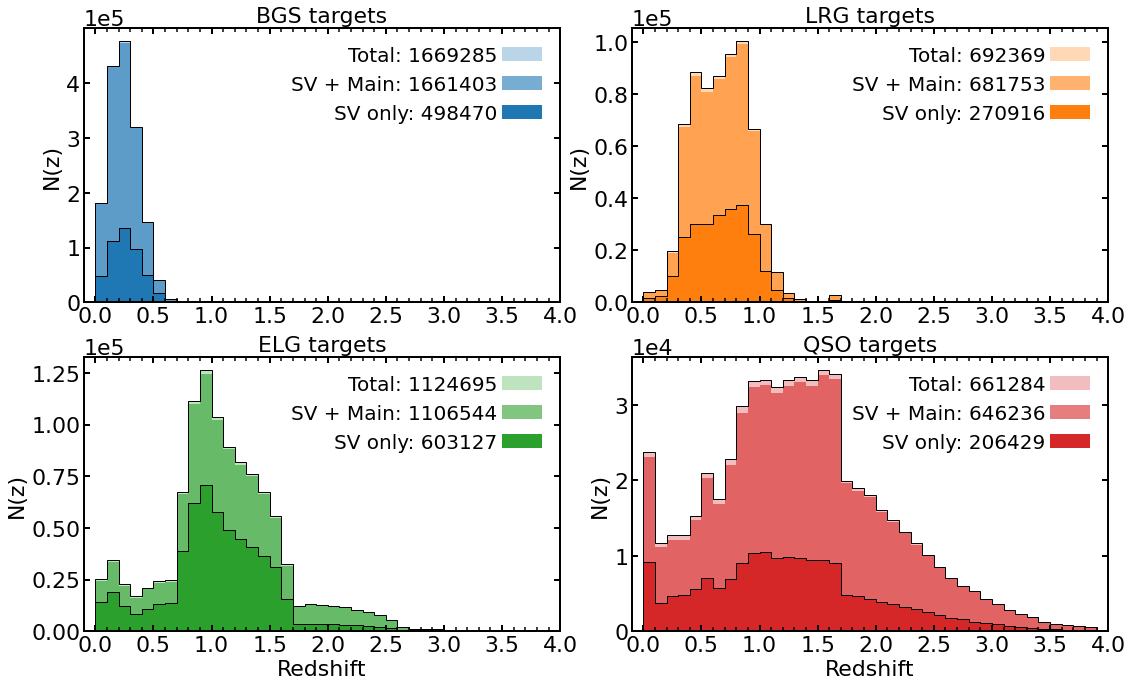

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))

bins = np.arange(0,4,0.1)

type_masks = (is_bgs, is_lrg, is_elg, is_qso)
colors     = ("C0","C1","C2","C3")

for ax,type_mask,name,color in zip(np.concatenate(axes), type_masks, targets[:-2], colors):
    kwargs = dict(color=color, bins=bins)
    
    ax.hist(fujilupe["Z"][type_mask], **kwargs, alpha=0.3, label=f"Total: {len(fujilupe[type_mask])}")
    ax.hist(fujilupe["Z"][type_mask], bins=bins, histtype="step", color="black")

    mask = type_mask & (is_main | is_sv)
    ax.hist(fujilupe["Z"][mask], **kwargs, alpha=0.6, label=f"SV + Main: {len(fujilupe[mask])}")
    
    mask = type_mask & is_sv
    ax.hist(fujilupe["Z"][mask], **kwargs, label=f"SV only: {len(fujilupe[mask])}")
    ax.hist(fujilupe["Z"][mask], bins=bins, histtype="step", color="black")
    
    ax.legend(fontsize=20, markerfirst=False, handletextpad=0.25, frameon=False)
    ax.set_title(f"{name} targets", fontsize=22)

for ax in axes[-1]:
    ax.set_xlabel("Redshift")

for ax in np.concatenate(axes):
    ax.set_xlim(-0.1,4.0)
    ax.set_xticks(np.arange(0,4.1,0.5))
    ax.set_ylabel("N(z)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.15)
plt.show()



### Target class versus Redrock spectral type

The above plot shows $N(z)$ for all *targets* of a given type, but [Redrock](https://github.com/desihub/redrock) will not necessarily classify all spectra as having the same spectral type as their original target class. For example, the following plot breaks down QSO targets by their Redrock spectral type (`GALAXY`, `QSO`, or `STAR`), contained in the `SPECTYPE` column.

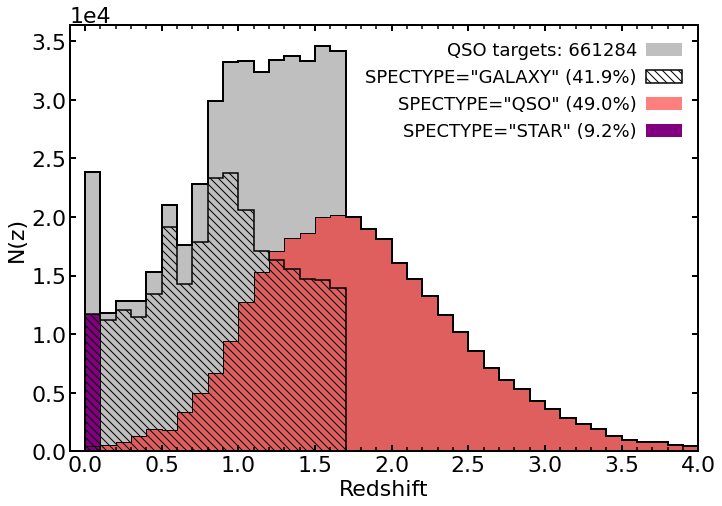

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10.5,7.5))

bins = np.arange(0,4.1,0.1)

#-- all QSO targets
ax.hist(fujilupe["Z"][is_qso], bins=bins, color="gray", alpha=0.5, label=f"QSO targets: {n_qso}")

#-- QSO targets classified as galaxies
spec_gal = is_qso & (fujilupe["SPECTYPE"]=="GALAXY")
ax.hist(fujilupe["Z"][spec_gal], bins=bins, histtype="step", hatch="\\\\\\", color="k", lw=1.5,
        label=f"SPECTYPE=\"GALAXY\" ({100*len(fujilupe[spec_gal])/n_qso:.1f}%)")

#-- QSO targets classified as quasars
spec_qso = is_qso & (fujilupe["SPECTYPE"]=="QSO")
ax.hist(fujilupe["Z"][spec_qso], bins=bins, color="red", alpha=0.5,
        label=f"SPECTYPE=\"QSO\" ({100*len(fujilupe[spec_qso])/n_qso:.1f}%)")
ax.hist(fujilupe["Z"][spec_qso], bins=bins, histtype="step", color="k", lw=1)

#-- QSO targets classified as stars
spec_star = is_qso & (fujilupe["SPECTYPE"]=="STAR")
ax.hist(fujilupe["Z"][spec_star], bins=bins, color="purple",
        label=f"SPECTYPE=\"STAR\" ({100*len(fujilupe[spec_star])/n_qso:.1f}%)")
ax.hist(fujilupe["Z"][spec_star], bins=bins, histtype="step", color="k", lw=1)

ax.hist(fujilupe["Z"][is_qso], bins=bins, histtype="step", color="black", lw=2)

ax.legend(fontsize=18, markerfirst=False, handletextpad=0.5, frameon=False)

ax.set_xlabel("Redshift")
ax.set_xlim(-0.1,4.0)
ax.set_xticks(np.arange(0,4.1,0.5))
ax.set_ylabel("N(z)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
plt.show()


Of the over 660k QSO targets in the combined catalog, only 49% are actually classified as quasars (red histogram) by Redrock. Nearly 42% are classified as galaxies (black hatched histogram), and the remaining 9% as stars (purple histogram at $z\sim0$). The abrupt drop in $N(z)$ at $z=1.7$ reflects the fact that Redrock is constrained to fit redshifts $z<1.7$ to spectra it classifies as galaxies.

<a class="anchor" id="counts_target_survey"></a>
## Target counts by target type and survey


In [15]:
#-- BGS
is_bgs_sv1 = (fujilupe["SV1_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv2 = (fujilupe["SV2_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv3 = (fujilupe["SV3_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv  = is_bgs_sv1 | is_bgs_sv2 | is_bgs_sv3 

#-- LRG
is_lrg_sv1 = (fujilupe["SV1_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv2 = (fujilupe["SV2_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv3 = (fujilupe["SV3_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv  = is_lrg_sv1 | is_lrg_sv2 | is_lrg_sv3

#-- ELG
is_elg_sv1 = (fujilupe["SV1_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv2 = (fujilupe["SV2_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv3 = (fujilupe["SV3_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv  = is_elg_sv1 | is_elg_sv2 | is_elg_sv3

#-- QSO
is_qso_sv1 = (fujilupe["SV1_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv2 = (fujilupe["SV2_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv3 = (fujilupe["SV3_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv  = is_qso_sv1 | is_qso_sv2 | is_qso_sv3

#-- Milky Way
is_mws_sv1 = (fujilupe["SV1_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv2 = (fujilupe["SV2_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv3 = (fujilupe["SV3_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv  = is_mws_sv1 | is_mws_sv2 | is_mws_sv3

#-- secondary
is_scnd_sv1 = (fujilupe["SV1_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv2 = (fujilupe["SV2_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv3 = (fujilupe["SV3_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv  = is_scnd_sv1 | is_scnd_sv2 | is_scnd_sv3


In [16]:
print("BGS    SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_bgs_sv]), len(fujilupe[is_bgs & ~is_bgs_sv]) ))
print("LRG    SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_lrg_sv]), len(fujilupe[is_lrg & ~is_lrg_sv]) ))

print("ELG    SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_elg_sv]), len(fujilupe[is_elg & ~is_elg_sv]) ))
print("QSO    SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_qso_sv]), len(fujilupe[is_qso & ~is_qso_sv]) ))

print("MWS    SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_mws_sv]), len(fujilupe[is_mws & ~is_mws_sv]) ))
print("SCND   SV:{0:8}\n     Main:{1:8}\n".format(len(fujilupe[is_scnd_sv]), len(fujilupe[is_scnd & ~is_scnd_sv]) ))


BGS    SV:  498470
     Main: 1170815

LRG    SV:  270916
     Main:  421453

ELG    SV:  603127
     Main:  521568

QSO    SV:  206429
     Main:  454855

MWS    SV:  536786
     Main:  307747

SCND   SV:  165039
     Main:  380047



<a class="anchor" id="multispec"></a>
## Targets with multiple spectra

As shown in the plot below, the vast majority of targets in the combined catalog have only one spectrum. About 3% of targets have two spectra, and only a few thousand have three, four, or five (the maximum).

Note that these numbers will be slightly different depending on whether the bad fiber quality cut has been applied to the combined catalog. If spectra associated with bad fibers are removed *after* `ZCAT_NSPEC` has been computed and added to the catalog, then some targets with `ZCAT_NSPEC`$\,=x$ (where $x>1$) may appear in the catalog fewer than $x$ times.


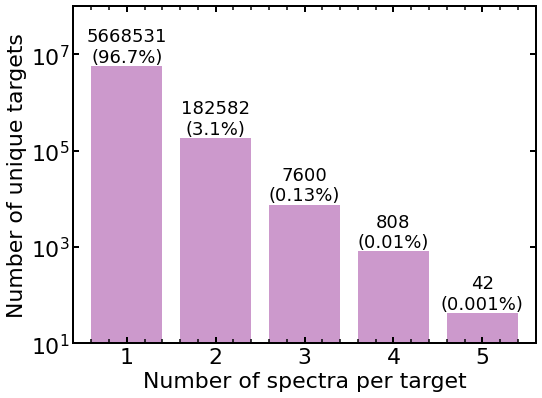

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

freq, hist = np.array(np.unique(fujilupe["ZCAT_NSPEC"], return_counts=True))
hist  = ( hist / np.arange(1,np.max(freq)+1) ).astype(int)
n_tot = sum(hist)
ax.bar(freq, hist, color="purple", alpha=0.4)

ax.set_xlabel("Number of spectra per target")
ax.set_xlim(0.4,5.6)
ax.set_ylabel("Number of unique targets")
ax.set_ylim(1e1,1e8)
ax.semilogy()

round_to = [1,1,2,2,3]
pct = [f"{np.round( 100*hist[i]/n_tot, round_to[i] )}" for i in range(len(round_to))]

for i in range(len(round_to)):
    ax.text(freq[i], hist[i], f"{hist[i]}\n({pct[i]}%)", ha="center", va="bottom", fontsize=18)

plt.tight_layout()
plt.show()


#### Below we'll look more closely at the targets with five spectra


In [18]:
#-- get all targets with NSPEC=5
t_fivespec = fujilupe[fujilupe["ZCAT_NSPEC"]==5]

#-- unique TARGETID of each object with five spectra
targids = np.unique(t_fivespec["TARGETID"])

print("\tTARGETID\t\tSPECTYPE of all 5 spectra")
for i,tid in enumerate(targids):
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    spectype   = these_spec["SPECTYPE"].data.astype(str)
    print("{0:3}\t{1}\t{2}".format(i+1, tid, spectype))


	TARGETID		SPECTYPE of all 5 spectra
  1	39627770203999135	['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY']
  2	39627770254333533	['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY']
  3	39627776310903423	['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY']
  4	39627788306612620	['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY']
  5	39627788306615617	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  6	39627800423957409	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  7	39627823471663007	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  8	39627823484243615	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  9	39627829507262519	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 10	39627829532428134	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 11	39627835551254147	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 12	39627835576420141	['STAR' 'STAR' 'STAR' 'STAR' 'GALAXY']
 13	39627835576420773	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 14	39627841582663670	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 15	39627841586860364	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 16	39627841620412935	['STAR' 'STAR'

Most of the targets with five spectra have been flagged as stars by Redrock. One object (12 above) has four spectra flagged as a star, but the fifth classification is a galaxy. Let's look more closely at this object.

<a class="anchor" id="spectype_diff"></a>
### Targets with multiple `SPECTYPE` classifications


In [19]:
#-- get the data for all observations of this TARGETID
these_spec = t_fivespec[ t_fivespec["TARGETID"]==targids[11] ]

#-- get the SURVEY, PROGRAM, SPECTYPE, and redshift values for each of the five spectra of this object
survey   = these_spec["SURVEY"].data.astype(str)
program  = these_spec["PROGRAM"].data.astype(str)
redshift = np.round(these_spec["Z"].data,5)
spectype = these_spec["SPECTYPE"].data.astype(str)

print("\tSURVEY  PROGRAM  SPECTYPE  REDSHIFT")
for i in range(5):
    print("{0:1}/5\t{1:7} {2:8} {3:8} {4:8}".format(i+1, survey[i], program[i], spectype[i], redshift[i]))


	SURVEY  PROGRAM  SPECTYPE  REDSHIFT
1/5	sv1     bright   STAR      0.00114
2/5	sv1     dark     STAR      0.00115
3/5	sv1     other    STAR      0.00114
4/5	sv3     bright   STAR       -0.002
5/5	sv3     dark     GALAXY    0.31616


The four spectra classified as `STAR` have $z\sim0$, while the redshift of the spectrum with the `GALAXY` classification is $z\sim0.316$. Let's plot several of these spectra to invesitgate the different in `SPECTYPE` classification and redshift measurement.

The `get_spec_data` function defined below is a convenience function to load the relevant data for plotting the spectrum for a given `TARGETID`, `SURVEY`, and `PROGRAM`. We will use it to load different spectra of the same object.

In [20]:
def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (fujilupe["TARGETID"]==tid) & (fujilupe["SURVEY"]==survey) & (fujilupe["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = fujilupe["HEALPIX"].astype(str)

    if "sv" in survey:
        specprod = "fuji"
    elif survey=="main":
        specprod = "guadalupe"

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/{specprod}"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==fujilupe["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec


In [21]:
#-- get the third, fourth, and fifth spectra for this object 

tid = targids[11] #-- TARGETID

#-- 3/5 above; SPECTYPE = STAR
sv1_other_star = get_spec_data(tid, survey="sv1", program="other")

#-- 4/5 above; SPECTYPE = STAR
sv3_bright_star = get_spec_data(tid, survey="sv3", program="bright")

#-- 5/5 above; SPECTYPE = GALAXY
sv3_dark_gal = get_spec_data(tid, survey="sv3", program="dark")


INFO:spectra.py:291:read_spectra: iotime 3.089 sec to read coadd-sv1-other-27256.fits at 2022-11-17T10:38:15.767390
INFO:spectra.py:291:read_spectra: iotime 13.688 sec to read coadd-sv3-bright-27256.fits at 2022-11-17T10:38:31.645353
INFO:spectra.py:291:read_spectra: iotime 18.006 sec to read coadd-sv3-dark-27256.fits at 2022-11-17T10:38:52.730938


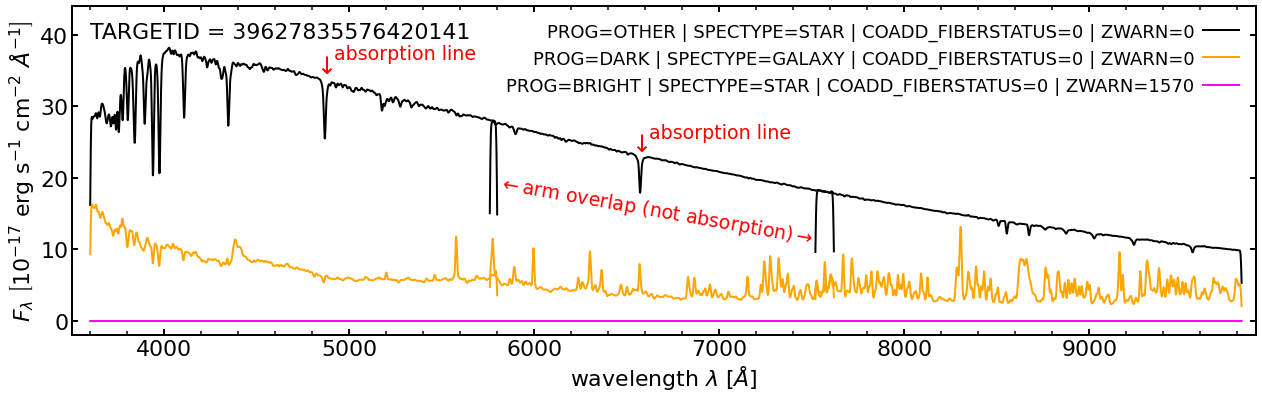

In [22]:
#-- plot the spectra

fig, ax = plt.subplots(1, 1, figsize=(18,6))

ax.set_xlim(3500, 9900)
ax.set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
ax.set_ylim(-2, 44)
ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

spectra = ( sv1_other_star, sv3_dark_gal, sv3_bright_star )
zwarn   = (0,0,1570)
coaddfs = (0,0,0)
for PROG,ST,spec,color,zw,cfs in zip( ("OTHER","DARK","BRIGHT"), ("STAR","GALAXY","STAR"), spectra, ("k","orange","magenta"), zwarn, coaddfs ):
    for band in ("b","r","z"):
        label = f"PROG={PROG} | SPECTYPE={ST} | COADD_FIBERSTATUS={cfs} | ZWARN={zw}" if band=="b" else ""
        ax.plot(spec.wave[band], convolve(spec.flux[band][0], Gaussian1DKernel(5)), label=label, color=color, lw=2)

ax.text(3600, 39, f"TARGETID = {tid}", ha="left", va="bottom")
ax.legend(markerfirst=False, fontsize=18, handletextpad=0.5, frameon=False)

#-- annotations
ax.text(5800, 10, r"$\leftarrow$" + "arm overlap (not absorption)" + r"$\rightarrow$", ha="left", va="bottom", fontsize=19, color="red", rotation=350)
ax.text(4800, 34, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
ax.text(6500, 23, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
ax.text(4920, 36, "absorption line", ha="left", va="bottom", fontsize=19, color="red")
ax.text(6620, 25, "absorption line", ha="left", va="bottom", fontsize=19, color="red")

plt.tight_layout()
plt.show()


The SV1 dark time spectrum (black line) is clearly a stellar spectrum and correctly classified by Redrock, while the shape of the SV3 "other" program spectrum (orange line) is somewhat ambiguous. It is not surpising that this spectrum was misclassified as a galaxy. The SV3 bright time spectrum (magenta line) obviously has no flux data, and it is not immediately clear why it was classified as a stellar spectrum. Below we'll look at additional columns for these spectra.


In [23]:
#-- show all data columns for the five spectra for this target

t_fivespec[ t_fivespec["TARGETID"]==tid ].show_in_notebook()


idx,TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF [10],NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,MAIN_NSPEC,MAIN_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
0,39627835576420141,sv1,bright,27256,27256,0.0011417368469184594,4.095495353706594e-06,0,8838.941289415088,6392.919297435823 .. 0.0,7927,STAR,F,5,13079.627106254098,0,150.8397829188431,2.0302946855385895,-7.495269,-3.4361079,2021.0883,2305843052163366912,3,TGT,0.27043005206214,7,9010,1508p020,342491,1837,PSF,0.01936283,68.24761,90.43967,96.551445,25.577448,13.073274,116.89038,54.455704,29.06246,2.3624856,0.5857435,53.075703,70.33431,75.0874,53.075706,70.33432,75.08743,0,0.0,0.0,0.0,0.0,3836010080046851072,G2,17.667353,17.877104,17.243767,0.68027276,S,1100,1,0,0,0,0,0,2305843052163366912,0,33,0,0,0,0,0,0,0,0,0,150.8397829188431,2.0302946855385895,7,6330.382,3,1,0.0035832778,0.0113409795,0.003084996,0.004722496,150.83978778997462,0.121175125,2.0302853254507016,0.053052835,0.789,55.40914,0.03674524,11.160031,28.527657,214.3489,97.019325,0.981001,0.37086573,3823.9243,8.938565,758.6612,0.018770928,859.0104,6279.485,2.623373,12.584695,7.656398e-06,44.699924,1.5386753e-06,0.0,1872.1166,1.3271912e-05,8.7765,19.009697,3879.3335,53.675236,769.8212,28.546427,2945.4758,6376.5044,12.380874,31.965258,5,False,0,False,5,False
1,39627835576420141,sv1,dark,27256,27256,0.0011481472801551324,8.767969364245273e-07,0,27157.4397228281,6342.946596010624 .. 0.0,7928,STAR,F,5,389563.493802269,0,150.83978316486633,2.030294866360465,-7.495269,-3.4361079,2020.9487,2305843052163366912,3,TGT,0.3132573305466272,7,9010,,342491,1837,PSF,0.01936283,68.24761,90.43967,96.551445,25.577448,13.073274,116.89038,54.455704,29.06246,2.3624856,0.5857435,53.075703,70.33431,75.0874,53.075706,70.33432,75.08743,0,0.0,0.0,0.0,0.0,3836010080046851072,G2,17.667353,17.877104,17.243767,0.68027276,S,1100,1,0,0,0,0,0,2305843052163366912,0,33,0,0,0,0,0,0,0,0,0,150.83978316486633,2.030294866360465,31,27455.465,6,2,-0.0006129032,0.008574155,0.0017096774,0.008232509,150.83978851531282,0.12263742,2.0303026265447923,0.117334686,0.789,3888.989,3.0252707,722.07825,3122.5254,14667.599,5096.7627,82.62242,23.044636,230674.23,467.24292,41044.355,0.91731435,48259.79,261390.17,151.73328,693.4119,0.00030713485,1587.981,5.7122452e-05,0.0,74759.35,0.00040694026,340.0303,755.2864,234563.22,2058.249,41766.434,3123.4426,137686.73,266486.94,574.386,1471.7429,5,False,0,False,5,False
2,39627835576420141,sv1,other,27256,27256,0.0011435554212226827,6.569065910730206e-07,0,50204.96818820806,6452.8813485135 .. 0.0,7928,STAR,F,5,628192.3800933082,0,150.83978256299

Looking at all the columns for these five spectra, we can see that all five have `COADD_FIBERSTATUS=0` (i.e., no bad fiber warning). However, the spectrum with no flux (4/5) has `ZWARN=1570`, while the other (good) spectra all have `ZWARN=0`. Scroll to the final column (`ZCAT_PRIMARY`) and we'll see that the third spectra (black line in the above plot) is the primary spectrum for this target.

<a class="anchor" id="bright_dark"></a>
### `BRIGHT` versus `DARK` program spectra of the same target

Now we'll look more closely at the `SURVEY`, `PROGRAM`, and redshift values of the four galaxy targets with five spectra.

In [24]:
for tid in targids[:4]:
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    survey   = these_spec["SURVEY"].data.astype(str)
    program  = these_spec["PROGRAM"].data.astype(str)
    redshift = these_spec["Z"].data
    print(f"TARGETID = {tid}")
    print("    Survey  \t{0}\t{1}\t{2}\t{3}\t{4}".format(*survey))
    print("    Program \t{0}\t{1}\t{2}\t{3}\t{4}".format(*program))
    print("    Redshift\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}\n".format(*redshift))


TARGETID = 39627770203999135
    Survey  	sv1	sv3	sv3	main	main
    Program 	other	bright	dark	bright	dark
    Redshift	0.4133	0.4131	0.4131	0.4132	0.4131

TARGETID = 39627770254333533
    Survey  	sv1	sv3	sv3	main	main
    Program 	other	bright	dark	bright	dark
    Redshift	0.3625	0.3624	0.3624	0.3623	0.3624

TARGETID = 39627776310903423
    Survey  	sv1	sv3	sv3	main	main
    Program 	other	bright	dark	bright	dark
    Redshift	0.5517	0.5513	0.5519	0.5511	0.5519

TARGETID = 39627788306612620
    Survey  	sv1	sv3	sv3	main	main
    Program 	other	bright	dark	bright	dark
    Redshift	0.4680	0.4680	0.4678	0.4684	0.4680



Each of these targets was observed once each during SV1, SV2, and SV3, and twice during the main survey (once each during the bright and dark programs). Note that for each object all five redshift measurements agree to at least the third or fourth decimal place.

Below we compare the dark and bright time spectra of this object from the main survey. The top panel shows the smoothed bright time spectrum in magenta against the smoothed dark time spectrum in black. The middle and bottom panels show the bright and dark time spectra, respectively, smoothed in black, as well as the flux from each arm (*B*, *R*, and *Z*) shown in blue, green, and red. As expected, the bright time spectrum is clearly nosier than the dark time. While the two spectra have very similar continuua, the $4000$ Angstrom break (gray dashed line; redshifted to $\sim5600\ {\rm A}$) is easier to identify in the dark time sepctrum.

In [25]:
#-- get two spectra for this object (first of the four galaxies with five spectra)

tid = targids[0] #-- TARGETID 

#-- get the DARK TIME spectrum
spec_dark = get_spec_data(tid, survey="main", program="dark")

#-- get the BRIGHT TIME spectrum
spec_bright = get_spec_data(tid, survey="main", program="bright")


INFO:spectra.py:291:read_spectra: iotime 1.667 sec to read coadd-main-dark-25917.fits at 2022-11-17T10:38:58.249458
INFO:spectra.py:291:read_spectra: iotime 1.898 sec to read coadd-main-bright-25917.fits at 2022-11-17T10:39:02.240036


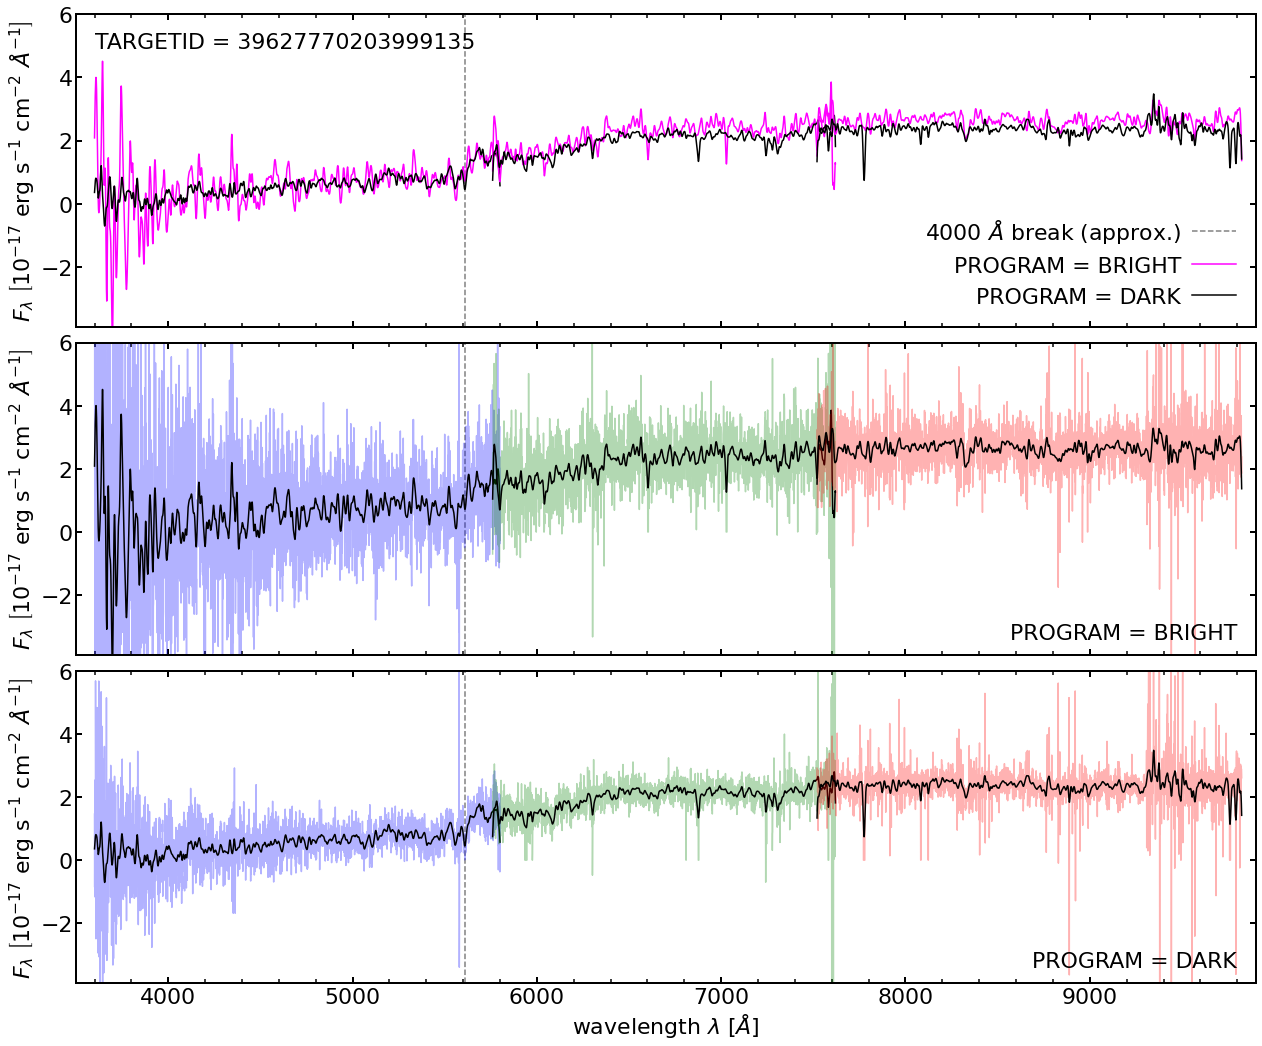

In [26]:
#-- plot the spectra

fig, axes = plt.subplots(3, 1, figsize=(18,15), sharex=True, sharey=True)

for ax in axes:
    ax.set_xlim(3500, 9900)
    ax.set_ylim(-3.9, 6)  #-- change depending on specific spectrum
    ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")
    ax.plot(5610*np.ones(2), ax.get_ylim(), color="gray", ls="--", label="$4000\ \AA$ break (approx.)")

axes[-1].set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")

#-- plot the BRIGHT TIME and DARK TIME spectra (both smoothed) on the same axis
for band in ("b","r","z"):
    if band=="z":
        label_bright = "PROGRAM = BRIGHT"
        label_dark   = "PROGRAM = DARK"
    else:
        label_bright = label_dark = ""
    axes[0].plot(spec_bright.wave[band], convolve(spec_bright.flux[band][0], Gaussian1DKernel(5)), color="magenta", label=label_bright)
    axes[0].plot(spec_dark.wave[band], convolve(spec_dark.flux[band][0], Gaussian1DKernel(5)), color="k", label=label_dark)
axes[0].legend(markerfirst=False, loc=4, handletextpad=0.5, frameon=False)
axes[0].text(3600, 0.8*axes[0].get_ylim()[1], f"TARGETID = {tid}", ha="left", va="bottom")

#-- plot the BRIGHT TIME and DARK TIME spectra at full resolution on separate axes
for ax,coadd_spec,prog in zip(axes[1:],(spec_bright,spec_dark),("BRIGHT","DARK")):
    ax.text(9800, 0.9*ax.get_ylim()[0], f"\nPROGRAM = {prog.upper()}", ha="right", va="bottom")
    for band,color in zip(("b","r","z"),("b","g","r")):
        #-- plot the spectrum from each arm (B,R,Z) in blue, green, red
        ax.plot(coadd_spec.wave[band], coadd_spec.flux[band][0], color=color, alpha=0.3)
        #-- add smoothed spectrum in black for all the three arms
        ax.plot(coadd_spec.wave[band], convolve(coadd_spec.flux[band][0], Gaussian1DKernel(5)), color="k")
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()
